# Team 88: Basic Exploratory Analysis
## Airport Traffic Data

From the initial review of this dataset, we identified variables of interest, useful supplementary variables from other datasets, and any needed cleaning was completed. Now with the variables and data set, we can find some insights from the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

%matplotlib inline

In [9]:
#import data
path = '/content/drive/MyDrive/2020-Move/Learning/DS4A-correlation-one/DS4A Project/repo/'
all_travel = pd.read_csv(path+'data/all_travel.csv').drop(['Unnamed: 0'], axis=1)
print(all_travel.shape,'\n')
all_travel.head(2)

(4288742, 11) 



,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,PASSENGERS,YEAR,QUARTER,ORIGIN_COUNTRY,ROUNDTRIP,ITIN_FARE
0,20111156458,11278,DCA,14771,SFO,1.0,2011,1,US,0.0,2112.0
1,20111156497,11618,EWR,14831,SJC,1.0,2011,1,US,0.0,394.0


After filtering the dataset to only include bay area inbound flights and aggregating all periods, we can graph a time series to see how the traffic changes over time, and what the most common origin locations are for visitors and nomads.

### Time Changes - High Level View:
For this high level check of how the last decade has gone. We will have a quarterly plot to check for seasonal changes of the time series. For the annual graph, we will only plot (for now) 2011-2019 for two reasons:
- We are not in an EDA deep dive yet
- We are still in Q4 2020 and COVID happens which means we can't really compare it to all other years without that added context
- Q4 2010 was only included to round out our quarters to 40 and our main focus starts in 2015-2020, so we are (for now), not losing much by not seeing this quarter and it will appear negligible because there is only one out of four quarters for 2010

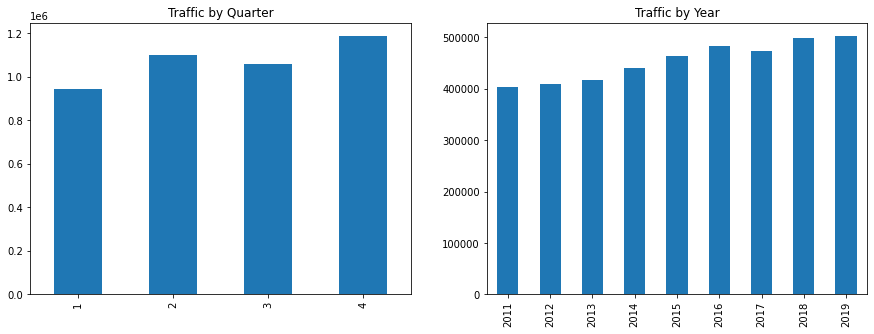

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
all_travel['QUARTER'].value_counts().sort_index().plot.bar(title='Traffic by Quarter', ax=ax1)
all_travel[all_travel['YEAR'].isin(range(2011,2020))]['YEAR'].value_counts().sort_index(ascending=True).plot.bar(title='Traffic by Year', ax=ax2)
plt.show()

A quick view of popular departure locations

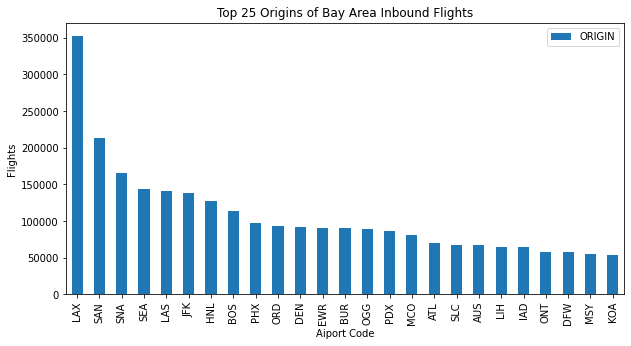

In [7]:
inbound_ct = pd.DataFrame(all_travel['ORIGIN'].value_counts())
fig, ax = plt.subplots(figsize=(10,5))
inbound_ct[:25].plot.bar(ax=ax)
ax.set(title='Top 25 Origins of Bay Area Inbound Flights', xlabel='Aiport Code', ylabel='Flights')
plt.show()

By far, most people fly in from LAX (Los Angeles International Airport) followed by a few west coast airports and some major hubs including New York (JFK) and Boston (BOS). Given that airport codes are not common knowledge, a supplemental file with the city names for each airport code is included and used to update the plot above for top 25 origin airports for other uses going forward.

The [Market Coordinate](https://www.transtats.bts.gov/Tables.asp?DB_ID=595&DB_Name=Aviation%20Support%20Tables) table download (`341379231_T_MASTER_CORD.csv`) that is also provided by the Bureau of Transportation Statistics as with [all our data](https://www.transtats.bts.gov/Tables.asp?DB_ID=125&DB_Name=Airline%20Origin%20and%20Destination%20Survey%20%28DB1B%29&DB_Short_Name=Origin%20and%20Destination%20Survey), includes information about airport codes, IDs, and location, along with any historical identifying information about the airports that appear on the itineraries downloaded.

In [10]:
airport_data = pd.read_csv(path+'data/341379231_T_MASTER_CORD.csv')
airport_data.shape

(18102, 14)

In [11]:
airport_data.head(2)

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_COUNTRY_NAME,AIRPORT_STATE_NAME,AIRPORT_STATE_FIPS,DISPLAY_CITY_MARKET_NAME_FULL,LAT_DEGREES,LATITUDE,LON_DEGREES,LONGITUDE,AIRPORT_IS_LATEST,Unnamed: 13
0,10001,01A,Afognak Lake Airport,"Afognak Lake, AK",United States,Alaska,2.0,"Afognak Lake, AK",58.0,58.109444,152.0,-152.906667,1,NaN
1,10003,03A,Bear Creek Mining Strip,"Granite Mountain, AK",United States,Alaska,2.0,"Granite Mountain, AK",65.0,65.548056,161.0,-161.071667,1,NaN


We established during exploration that the parameter that will be used to connect these two datasets is the airport ID = a five digit value that is unique to the airport as the three alphanumeric digit codes tend to be reassigned or retired.

In [12]:
#checking uniqueness by before merging/ removing duplicates
airport_data = airport_data.drop_duplicates(subset=['AIRPORT_ID'])
airport_data.shape

(6548, 14)

In [13]:
#create temporary columns for merging
airport_data['ORIGIN_AIRPORT_ID'] = airport_data['AIRPORT_ID']
airport_data['DEST_AIRPORT_ID'] = airport_data['AIRPORT_ID']
airport_data['ORIGIN_CITY_NAME'] = airport_data['DISPLAY_AIRPORT_CITY_NAME_FULL']
airport_data['DEST_CITY_NAME'] = airport_data['DISPLAY_AIRPORT_CITY_NAME_FULL']
airport_data.iloc[:, -4:].head(2)

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_CITY_NAME
0,10001,10001,"Afognak Lake, AK","Afognak Lake, AK"
1,10003,10003,"Granite Mountain, AK","Granite Mountain, AK"


There are also unused columns from the datasets that we can drop. Additionally now that we have the location information about the airport, we can use it for analysis and have a better representation for the top departure locations

In [14]:
#dropping unused/useless columns
del airport_data['Unnamed: 13']
airport_data.head(2)

,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_COUNTRY_NAME,AIRPORT_STATE_NAME,AIRPORT_STATE_FIPS,DISPLAY_CITY_MARKET_NAME_FULL,LAT_DEGREES,LATITUDE,LON_DEGREES,LONGITUDE,AIRPORT_IS_LATEST,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_CITY_NAME
0,10001,01A,Afognak Lake Airport,"Afognak Lake, AK",United States,Alaska,2.0,"Afognak Lake, AK",58.0,58.109444,152.0,-152.906667,1,10001,10001,"Afognak Lake, AK","Afognak Lake, AK"
1,10003,03A,Bear Creek Mining Strip,"Granite Mountain, AK",United States,Alaska,2.0,"Granite Mountain, AK",65.0,65.548056,161.0,-161.071667,1,10003,10003,"Granite Mountain, AK","Granite Mountain, AK"


In [15]:
#merge to larger dataset by airport ID
travel_df = pd.merge(all_travel, airport_data[['ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME']])
travel_df = pd.merge(travel_df, airport_data[['DEST_AIRPORT_ID', 'DEST_CITY_NAME']])
travel_df.head(2)

,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,PASSENGERS,YEAR,QUARTER,ORIGIN_COUNTRY,ROUNDTRIP,ITIN_FARE,ORIGIN_CITY_NAME,DEST_CITY_NAME
0,20111156458,11278,DCA,14771,SFO,1.0,2011,1,US,0.0,2112.0,"Washington, DC","San Francisco, CA"
1,20111385579,11278,DCA,14771,SFO,1.0,2011,1,US,1.0,315.0,"Washington, DC","San Francisco, CA"


In [16]:
travel_df.shape

(4288742, 13)

In [17]:
travel_df.columns

Index(['ITIN_ID', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST',
       'PASSENGERS', 'YEAR', 'QUARTER', 'ORIGIN_COUNTRY', 'ROUNDTRIP',
       'ITIN_FARE', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME'],
      dtype='object')

Now that we have merged our data, we can look into some descriptive statistics and distributions for different features. First a description of what each feature means. All of these descriptions come from the data source.
- `ITIN_ID` = Itinerary ID
- `ORIGIN_AIRPORT_ID` = Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- `ORIGIN` = Origin Airport Code
- `DEST_AIRPORT_ID` = Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.
- `DEST` = Destination Airport Code
- `PASSENGERS` = Number of Passengers for the itinerary
- `YEAR` = Year
- `QUARTER` = Quarter (1-4)
- `ORIGIN_COUNTRY` = Origin Airport, Country Code
- `ROUNDTRIP` = Round Trip Indicator (1=Yes)
- `ITIN_FARE` = Itinerary Fare Per Person
- `ORIGIN_CITY_NAME` = collected as `AirportCityName`: Airport City Name with either U.S. State or Country
- `DEST_CITY_NAME` = collected as `AirportCityName`: Airport City Name with either U.S. State or Country

In [18]:
#segment features for later analysis
num_features = ['PASSENGERS', 'ITIN_FARE']
encoded = ['YEAR', 'QUARTER', 'ITIN_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'ROUNDTRIP']
cat_features = ['ORIGIN' ,'DEST', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME']

In [19]:
travel_df[num_features].describe()

,PASSENGERS,ITIN_FARE
count,4.288742e+06,4.288742e+06
mean,2.826867e+00,4.875320e+02
std,1.008992e+01,4.195154e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,2.660000e+02
50%,1.000000e+00,4.130000e+02
75%,2.000000e+00,5.980000e+02
max,7.830000e+02,2.865700e+04


In [20]:
travel_df[cat_features].describe()

,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME
count,4288742,4288742,4288742,4288742
unique,441,4,434,4
top,LAX,SFO,"Los Angeles, CA","San Francisco, CA"
freq,352768,2566295,352768,2566295


### Quick Hits:
- Most itineraries are booked for 2 people (up to the 75th percentile). There is a maximum outlier with an itinerary of 783 people.
- Most of the total airfare associated with an itinerary (also comparing the 75th percentile) is just short of \$600 dollars per person on the itinerary
- Los Angeles, CA (LAX airport) remains the top departure location. This is understandable because this is an international hub with a lot of connecting flights to and from worldwide locations
- San Francisco, CA (through SFO airport) for similar reasons to LAX in Los Angeles, CA reigns as the most common destination airport for Bay Area inbound flights


### Changes over Time - A Detailed View
With these two major airports as international hubs, we can start the detailed time series view by looking at how traffic at these locations has changed over time. Note - we established that the airport codes for these two airports have not changed or been repurposed in the last ten years represented in our data.

In [21]:
#grouping data for plots
time_df = travel_df.groupby(by=['YEAR','QUARTER','ORIGIN','DEST']).count().reset_index().iloc[:,:5]
time_df.head(2)

,YEAR,QUARTER,ORIGIN,DEST,ITIN_ID
0,2010,4,ABE,OAK,1
1,2010,4,ABE,SFO,57


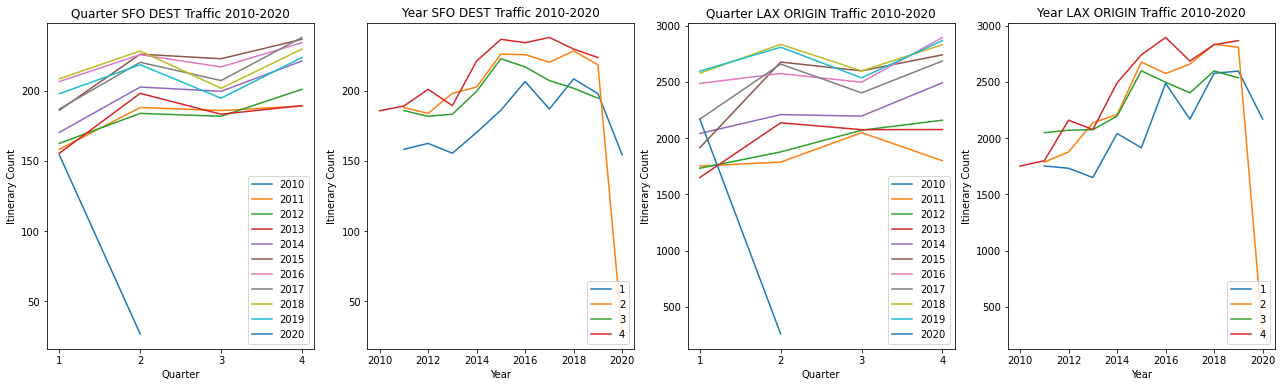

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(22,6))
#plot SFO destinations and LAX departures over time
axes = (ax1, ax2, ax3, ax4)
titles = ['QUARTER', 'YEAR']*2
cities, places = ['SFO', 'SFO', 'LAX', 'LAX'], ['DEST', 'DEST', 'ORIGIN', 'ORIGIN']

for loc, place, title, ax in zip(cities, places, titles, axes):
    sns.lineplot(x=title, y='ITIN_ID', 
    hue=titles[titles.index(title)+1], data=time_df[time_df[place]==loc], ci=None, palette='tab10', ax=ax)
    ax.set(xlabel=title.title(), ylabel='Itinerary Count', title=title.title()+' '+loc+' '+place+' Traffic 2010-2020')
    if title =='QUARTER': 
        ax.locator_params(nbins=4, axis='x')
    ax.legend(loc='lower right')

plt.show()

### Some Takeaways
- As expected, 2020 deviates a lot from the rest of the yearly and quarterly flows.
- Throughout the years, the amount of travel planned and completed based on review of the itineraries, has gone up overall. 2012-2015 was a slow period, and for most quarters, 2016 saw the biggest jump for both LAX and SFO in travel movement
- Quarterly, it seems there are cyclical trends with Q4 seeing the most travel jumps for most years. This tends to coincide with a lot of western holidays, especially in the U.S. including Thanksgiving and Christmas, so this makes some sense when compared to activities around that time. 

### Itineraries and Airfare
We noted above that there are some outliers for the airfare and itinerary passengers. It would be good to understand whether there are some itineraries that can be excluded so that the sample is a better representation of the typical activity and spend expectation for a person traveling to the Bay Area from different areas around the country.

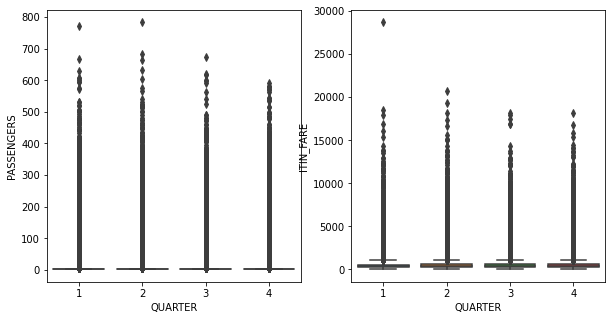

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(x='QUARTER', y='PASSENGERS', data=travel_df, ax=ax1)
sns.boxplot(x='QUARTER', y='ITIN_FARE', data=travel_df, ax=ax2)
plt.show()

There are clearly outliers that are making it hard to interpret the values for these two features. To give them both enough respect, there are two specifications.  
1. 75th percentile of both itinerary fare and number of passengers  
2. Top quarter of both itinerary fare and number of passengers

In [26]:
travel_df[num_features].describe()

,PASSENGERS,ITIN_FARE
count,4.288742e+06,4.288742e+06
mean,2.826867e+00,4.875320e+02
std,1.008992e+01,4.195154e+02
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,2.660000e+02
50%,1.000000e+00,4.130000e+02
75%,2.000000e+00,5.980000e+02
max,7.830000e+02,2.865700e+04


In [27]:
#segment data by percentiles
travel_75 = travel_df[(travel_df['PASSENGERS']<=2) & (travel_df['ITIN_FARE']<=598)]
travel_25 = travel_df[(travel_df['PASSENGERS']>2) & (travel_df['ITIN_FARE'] >598)]

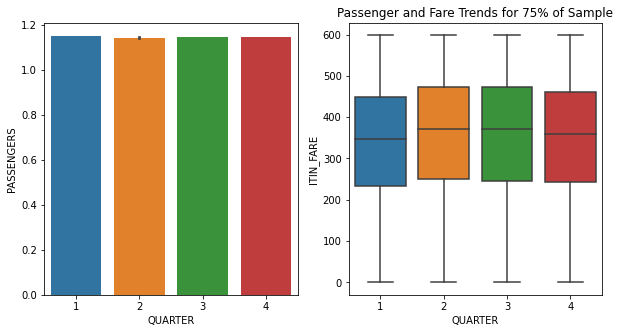

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.barplot(x='QUARTER', y='PASSENGERS', data=travel_75, ax=ax1)
sns.boxplot(x='QUARTER', y='ITIN_FARE', data=travel_75, ax=ax2)
plt.title('Passenger and Fare Trends for 75% of Sample')
plt.show()

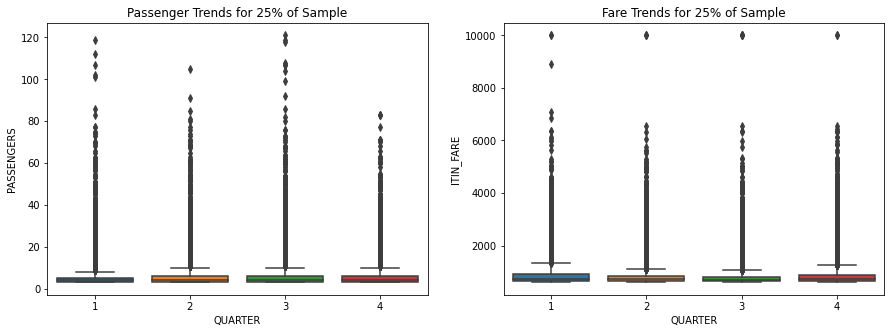

In [39]:
#top 25 percent
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.set_title('Passenger Trends for 25% of Sample')
ax2.set_title('Fare Trends for 25% of Sample')
sns.boxplot(x='QUARTER', y='PASSENGERS', data=travel_25, ax=ax1)
sns.boxplot(x='QUARTER', y='ITIN_FARE', data=travel_25, ax=ax2)
plt.show()

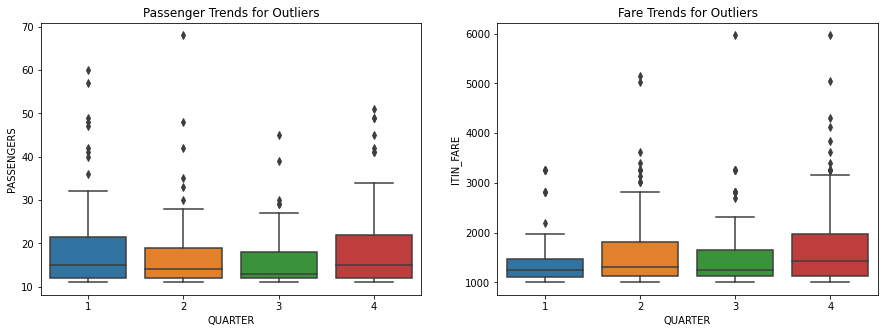

In [40]:
#even more because the 25% top is still very skewed
travel_outliers = travel_df[(travel_df['PASSENGERS']>10) & (travel_df['ITIN_FARE'] >1000)]

#plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.set_title('Passenger Trends for Outliers')
ax2.set_title('Fare Trends for Outliers')
sns.boxplot(x='QUARTER', y='PASSENGERS', data=travel_outliers, ax=ax1)
sns.boxplot(x='QUARTER', y='ITIN_FARE', data=travel_outliers, ax=ax2)
plt.show()

For a more detailed exploration, it would be useful for us to review these groups as bins because there is a good amount of data for each segment that was roughly created above. The next steps will be used to determine which groups reveal the most insight, and how these trends interact with the other datasets.